# LSTM scaling
After successfully optimizing a LSTM based neural network to predict wildfire risk in one California geopsatial bin, the next step is scale the model to make predictions for all 410 geospatial bins. A parallel LSTM architecture will be employed. Each of the 410 geospatial bins in California will get it's own input layer and LSTM layer, these will then be concatenated via a merge layer. The model output will be a 410 member vector where each element represents the prediction for one of the original geospatial bins.

### Goal: 
Scale LSTM neural network to make predictions for all 410 geospatial bins in California. Save trained model weights and optimized hyperparameters for deployment.

### Plan:
1. Prep data from one geospatial bin for input into LSTM
2. Build parallel LSTM model
3. Using hyperparameters from the single LSTM model as a starting point, tune and evaluate the parallel LSTM model.
4. Save trained model weights and hyperparameters for model deployment

# Notebook setup

In [1]:
import os
import sys
import logging
import tensorflow as tf

# Note: tf 2.1.0 give warning about model weight format when
# using class weights. This is the only way to silence without
# updating
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(42)

import numpy as np
np.random.seed(42)

import pandas as pd
import tensorflow as tf
import sklearn as sk
from pickle import dump

from tensorflow import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras import backend as K
from tensorflow.python.client import device_lib

# Note: sklearn forces depreciation warnings
# This is the only way to silence them without updating
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

import helper_functions.plotting_functions as plotting_functions
import helper_functions.data_functions as data_functions
import helper_functions.config as config

print(f"Python {sys.version}")
print()
print(f"Pandas {pd.__version__}")
print(f"Tensorflow {tf.__version__}")
print(f"Keras {keras.__version__}")
print(f"SciKit Learn {sk.__version__}")
print()

devices = device_lib.list_local_devices()

if 'GPU' in ('').join(str(devices)):
    print("tf accessable GPU found: "+devices[-2].physical_device_desc)

Python 3.7.7 (default, Mar 23 2020, 22:36:06) 
[GCC 7.3.0]

Pandas 1.0.3
Tensorflow 2.1.0
Keras 2.2.4-tf
SciKit Learn 0.22.1

tf accessable GPU found: device: 0, name: GeForce GTX 1070, pci bus id: 0000:02:00.0, compute capability: 6.1


In [2]:
# load configuration variables
data_file = config.training_data_file

features = config.features
features_to_scale = config.features_to_scale
months = config.months

left = config.left
right = config.right
bottom = config.bottom
top = config.top
wspace = config.wspace
hspace = config.hspace
fig_rows = config.fig_rows
fig_cols = config.fig_cols
plot_height = config.plot_height
plot_width = config.plot_width
plot_locations = config.plot_locations

metrics = config.metrics

# 1. Data preparation

In [3]:
# read data and grab features of intrest
raw_data = pd.read_parquet(data_file)
data = raw_data[features]

In [4]:
num_fires = data['ignition'].sum()
total_observations = len(data)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3594060 entries, 0 to 3594059
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   lat               float32       
 1   lon               float32       
 2   mean_air_2m       float32       
 3   mean_apcp         float32       
 4   mean_rhum_2m      float32       
 5   mean_dpt_2m       float32       
 6   mean_pres_sfc     float32       
 7   mean_uwnd_10m     float32       
 8   mean_vwnd_10m     float32       
 9   mean_cloud_cover  float32       
 10  ignition          float32       
 11  date              datetime64[ns]
dtypes: datetime64[ns](1), float32(11)
memory usage: 178.2 MB


In [6]:
class_0_weight = ()
class_1_weight = ()
bins = data.groupby(['lat', 'lon'])

for name, spatial_bin in bins:
    fires = spatial_bin['ignition'].sum()
    observations = len(spatial_bin)
    class_0_weight = class_0_weight + (((1 / (observations - fires))*(observations)/2.0),)
    class_1_weight = class_1_weight + (((1 / num_fires)*(total_observations)/2.0),)

### One hot encode month

In [7]:
onehot_encoder = OneHotEncoder(sparse=False)

# get months from each row of data, reshape from wide to long
month = np.array(pd.DatetimeIndex(data['date']).month).reshape(-1, 1)

# onehot encode
onehot_month = onehot_encoder.fit_transform(month)

# convert to pandas dataframe with named columns
onehot_month_df = pd.DataFrame(onehot_month, columns=months)

# set type to int
onehot_month_df = onehot_month_df.astype('int32')

# reset indexes
onehot_month_df.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

# join months back to data along rows
data = pd.concat([data, onehot_month_df], axis=1)

### Feature scaling and normalization
Next, we will use the Box-Cox transform to enforce a normal distribution on our data, then use a min-max scaler to put it the range (-1, 1) so that it matches the effective range of the tanh activation function used by the LSTM layer.

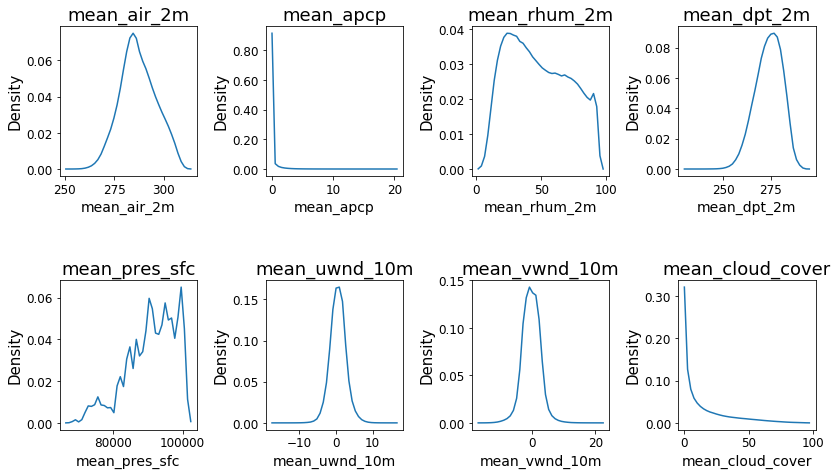

In [8]:
# plot weather data distributions before scaling
xlabels = features_to_scale
ylabels = ['Density'] * len(features_to_scale)

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features_to_scale)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        data, 
        features_to_scale[i], 
        features_to_scale[i], 
        features_to_scale[i], 
        ylabels[i]
    )

As you can see, some of the weather variables are somewhat normally distributed and some are far from it. The ranges also vary widely. Lets do what we can to fix that before the training phase.

In [9]:
# use box-cox to enforce normal distributions on data
qt = QuantileTransformer(random_state = 0, output_distribution = 'normal')
normalized_data = pd.DataFrame(qt.fit_transform(data[features_to_scale]), columns=features_to_scale)
data[features_to_scale] = normalized_data
dump(qt, open('./data_transformations/quantile_transformer', 'wb'))

# min-max scale data into (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_features = scaler.fit_transform(data[features_to_scale])
data[features_to_scale] = scaled_features
dump(scaler, open('./data_transformations/min_max_scaler', 'wb'))

# reset dtype
data[features_to_scale] = data[features_to_scale].astype('float32')

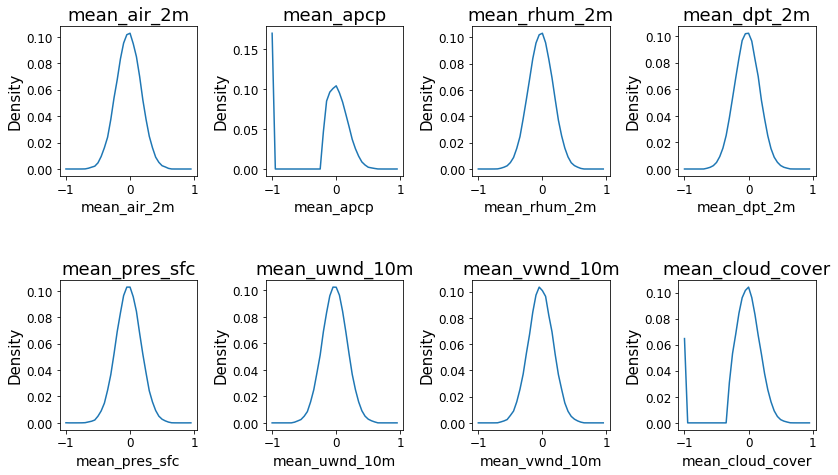

In [10]:
# plot weather data distributions after scaling
xlabels = features_to_scale
ylabels = ['Density'] * len(features_to_scale)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features_to_scale)):
    ax[plot_locations[i]] = plotting_functions.one_sample_density_plot(
        ax,
        plot_locations[i], 
        data, 
        features_to_scale[i], 
        features_to_scale[i], 
        features_to_scale[i], 
        ylabels[i]
    )
    
plt.show()

Except for vegetation coverage and categorical rain, the distributions now look much better.

### Split data into training, validation and testing sets
Note: since temporal order matters here, we cannot simply randomly sample the data - we need to preserve the order. One possible improvement could be to break the data into many smaller ordered chunks and then sample those randomly...

In [11]:
# data_first = data[(data['lat'] == 32.683891) & (data['lon'] == -117.180901)]
# data_last = data[(data['lat'] == 41.971821) & (data['lon'] == -121.290199)]
# data = pd.concat([data_first, data_last])

In [12]:
class_0_weight = ()
class_1_weight = ()
bins = data.groupby(['lat', 'lon'])

for name, spatial_bin in bins:
    fires = spatial_bin['ignition'].sum()
    observations = len(spatial_bin)
    class_0_weight = class_0_weight + (((1 / (observations - fires))*(observations)/2.0),)
    class_1_weight = class_1_weight + (((1 / (fires + K.epsilon()))*(observations)/2.0),)

In [13]:
# make sure data is sorted by date, then drop date column
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data = data.sort_index()
data.reset_index(inplace=True)#, drop=True)

In [14]:
# Split data up into training, testing and validation sets
testing_data = data.tail(int(len(data) * 0.25))
leftover_data = data.head(int(len(data) * 0.75))
validation_data = data.tail(int(len(leftover_data) * 0.5))
training_data = data.head(int(len(leftover_data) * 0.5))

Let's compare the distributions of each weather variable across the train, validation and test sets just to be sure that our samples are matched to a first approximation.

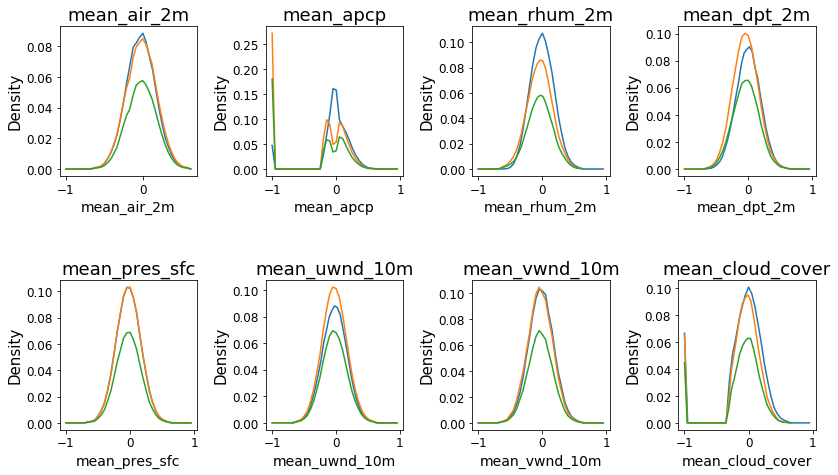

In [15]:
# plot split data distributions
xlabels = features_to_scale
ylabels = ['Density'] * len(features_to_scale)

# Make density plots
fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for i in range(len(features_to_scale)):
    ax[plot_locations[i]] = plotting_functions.three_sample_density_plot(
        ax,
        plot_locations[i], 
        training_data, 
        validation_data, 
        testing_data, 
        features_to_scale[i], 
        features_to_scale[i], 
        features_to_scale[i], 
        ylabels[i]
    )
    
plt.show()

### Format data for parallel LSTM
This part is a bit tricky - we need to form our data into samples, each sample containing 5 days of past history. Then we need a sequence of samples which spans the data set for each geospatial bin. Therefore, our input data will be a 410 member list of numpy arrays. The labels will be formated such that the first dimension is time and each time step contains a 410 member vector, one element for each of the 410 bins we are making predictions for.

In [16]:
num_fires = data['ignition'].sum()
total_observations = len(data)

print("Fires observed: {}".format(num_fires))
print("Total observations: {}".format(total_observations))
print()
print("Training data: {} observations".format(len(training_data)))
print("Validation data: {} observations".format(len(validation_data)))
print("Testing data: {} observations".format(len(testing_data)))

Fires observed: 231024.0
Total observations: 3594060

Training data: 1347772 observations
Validation data: 1347772 observations
Testing data: 898515 observations


In [17]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1347772 entries, 0 to 1347771
Data columns (total 24 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   date              1347772 non-null  datetime64[ns]
 1   lat               1347772 non-null  float32       
 2   lon               1347772 non-null  float32       
 3   mean_air_2m       1347772 non-null  float32       
 4   mean_apcp         1347772 non-null  float32       
 5   mean_rhum_2m      1347772 non-null  float32       
 6   mean_dpt_2m       1347772 non-null  float32       
 7   mean_pres_sfc     1347772 non-null  float32       
 8   mean_uwnd_10m     1347772 non-null  float32       
 9   mean_vwnd_10m     1347772 non-null  float32       
 10  mean_cloud_cover  1347772 non-null  float32       
 11  ignition          1347772 non-null  float32       
 12  October           1347772 non-null  int32         
 13  July              1347772 non-null  int32 

In [18]:
# Split data into 410 member lists, one element for each geospatial bin (and network input)
# each element of the list contains samples with a duration of past_history

past_history = 5
future_target = 1
step = 1

x_training, y_training = data_functions.format_features_labels_for_LSTM(
    training_data,        # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_validation, y_validation = data_functions.format_features_labels_for_LSTM(
    validation_data,      # incomming_data
    past_history,         # size of past history time chun
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_testing, y_testing = data_functions.format_features_labels_for_LSTM(
    testing_data,         # incomming_data
    past_history,         # size of past history time chun
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

In [19]:
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_training is <class 'list'>, length: 410, member shape: (3281,).

x_validation is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_validation is <class 'list'>, length: 410, member shape: (3281,).

x_testing is <class 'list'>, length: 410, member shape: (2186, 5, 22).
y_testing is <class 'list'>, length: 410, member shape: (2186,).


In [20]:
x_training, y_training = data_functions.trim_and_reshape_for_LSTM(x_training, y_training)
x_validation, y_validation = data_functions.trim_and_reshape_for_LSTM(x_validation, y_validation)
x_testing, y_testing = data_functions.trim_and_reshape_for_LSTM(x_testing, y_testing)

In [21]:
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_training is <class 'list'>, length: 3281, member shape: (410,).

x_validation is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_validation is <class 'list'>, length: 3281, member shape: (410,).

x_testing is <class 'list'>, length: 410, member shape: (2185, 5, 22).
y_testing is <class 'list'>, length: 2185, member shape: (410,).


In [22]:
# Trim each sample again to be a multiple of the batch size so we
# can do minibatch gradient descent - Note: this is required for statefull LSTMs

BATCH_SIZE = 64

for i in range(len(x_training)):
    start_index = (x_training[i].shape[0] - (x_training[i].shape[0] % BATCH_SIZE))
    end_index = x_training[i].shape[0]

    x_training[i] = np.delete(x_training[i], range(start_index, end_index), axis=0)

y_training = np.delete(y_training, range(start_index, end_index), axis=0)

for i in range(len(x_validation)):
    start_index = (x_validation[i].shape[0] - (x_validation[i].shape[0] % BATCH_SIZE))
    end_index = x_validation[i].shape[0]

    x_validation[i] = np.delete(x_validation[i], range(start_index, end_index), axis=0)

y_validation = np.delete(y_validation, range(start_index, end_index), axis=0)

for i in range(len(x_testing)):
    start_index = (x_testing[i].shape[0] - (x_testing[i].shape[0] % BATCH_SIZE))
    end_index = x_testing[i].shape[0]

    x_testing[i] = np.delete(x_testing[i], range(start_index, end_index), axis=0)

y_testing = np.delete(y_testing, range(start_index, end_index), axis=0)

In [23]:
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print()
print("x_validation is {}, length: {}, member shape: {}.".format(type(x_validation), len(x_validation), x_validation[0].shape))
print("y_validation is {}, length: {}, member shape: {}.".format(type(y_validation), len(y_validation), y_validation[0].shape))
print()
print("x_testing is {}, length: {}, member shape: {}.".format(type(x_testing), len(x_testing), x_testing[0].shape))
print("y_testing is {}, length: {}, member shape: {}.".format(type(y_testing), len(y_testing), y_testing[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3264, 5, 22).
y_training is <class 'numpy.ndarray'>, length: 3264, member shape: (410,).

x_validation is <class 'list'>, length: 410, member shape: (3264, 5, 22).
y_validation is <class 'numpy.ndarray'>, length: 3264, member shape: (410,).

x_testing is <class 'list'>, length: 410, member shape: (2176, 5, 22).
y_testing is <class 'numpy.ndarray'>, length: 2176, member shape: (410,).


# 2. Build parallel LSTM model
The general model architecture is as follows - 410 input layers, one for each geospatial bin. Each input feeds into it's own LSTM layer. The LSTM layers are then concatenated and make there way through a number of fully connected layers and finally to a 410 member sigmoid activated output.

The loss function used is weighted binary cross-entropy. As this is a multilabel classification, not a multiclass classification softmax and categorical cross-entropy are not good choices because we can have more than one positive output amount the 410 for each time step.

In [24]:
# hyperparameters (adapted from single LSTM Cassandra model)
learning_rate = 0.0001
parallel_lstm_units = 10
hidden_units = 10
hidden_l1_lambda = 0.3
variational_dropout = 0.2

raw_output_bias = np.log([num_fires/(total_observations - num_fires)])[0]
output_bias = tf.keras.initializers.Constant(raw_output_bias)

print(f'Inital output bias: {raw_output_bias}')
print(f'Class 0 weight: {class_0_weight}')
print(f'Class 1 weight: {class_1_weight}')

metrics = [
    keras.metrics.TruePositives(name='true_positives'),
    keras.metrics.FalsePositives(name='false_positives'),
    keras.metrics.TrueNegatives(name='true_negatives'),
    keras.metrics.FalseNegatives(name='false_negatives'), 
    keras.metrics.AUC(name='auc'),
    data_functions.matthews_correlation
]

Inital output bias: -2.6780778151820326
Class 0 weight: (0.5169241655855643, 0.6603887298478228, 0.6390144335909025, 0.5384520884520885, 0.5028105999770563, 0.5016021972991531, 0.5074678707884682, 0.5129315389116442, 0.5443368107302533, 0.5229062276306371, 0.6174109029440766, 0.5491104986218993, 0.5026376146788991, 0.5026376146788991, 0.5019468621163536, 0.5006854009595614, 0.5019468621163536, 0.5817626758693921, 0.5995896032831737, 0.5262968299711815, 0.5028682882055989, 0.5103632976245924, 0.5009142857142858, 0.5002282583884958, 0.5051867219917012, 0.5127515208235844, 0.5293478260869565, 0.6406958047069142, 0.614554122265844, 0.5480120030007503, 0.6873137839109299, 0.5601277955271565, 0.5079972183588317, 0.5121523720495443, 0.5058864265927978, 0.5332116788321168, 0.5014874141876431, 0.5077030001158346, 0.8335869151768733, 0.7262634631317316, 0.6477978125923737, 0.5840106595602932, 0.5085866790438617, 0.50929584011155, 0.5003424657534247, 0.5174734356552538, 0.5010288065843621, 0.5585

In [25]:
# inputs = []

# # make list of inputs, one for each geospatial bin
# for i in range(len(x_training)):
#     inputs.append(
#         keras.Input(
#             batch_shape=(
#                 BATCH_SIZE,
#                 x_training[0].shape[1],
#                 x_training[0].shape[2]
#             )
#         )
#     )
    
# # merge LSTM layers with concat layer
# merged = keras.layers.concatenate(inputs)

# LSTM = keras.layers.LSTM(
#         200,
#         dropout = variational_dropout,
#         stateful = True
# )(merged)

# # output layer
# output = keras.layers.Dense(
#     len(x_training),
#     activation = 'sigmoid',
#     bias_initializer = output_bias
# )(LSTM)

# # compile model
# model = keras.Model(inputs=inputs, outputs=output)

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(lr = learning_rate),
#     loss = data_functions.weighted_bce(class_0_weight, class_1_weight),
#     metrics = metrics
# )

# print(model.summary())

In [26]:
inputs = []
LSTMs = []
fully_connected_layers = []

# make list of inputs, one for each geospatial bin
for i in range(len(x_training)):
    inputs.append(
        keras.Input(
            batch_shape=(
                BATCH_SIZE,
                x_training[0].shape[1],
                x_training[0].shape[2]
            )
        )
    )
    
# make list of LSTM layers, one for each geospatial bin
for i in range(len(x_training)):
    LSTMs.append(keras.layers.LSTM(
        parallel_lstm_units,
        dropout = variational_dropout,
        stateful = True
    )(inputs[i]))
    
# make list of hidden layers, one for each geospatial bin
for i in range(len(x_training)):
    fully_connected_layers.append(keras.layers.Dense(
        hidden_units,
        kernel_regularizer=keras.regularizers.l2(hidden_l1_lambda),
#         bias_initializer=tf.keras.initializers.he_normal(),
        activation = 'relu'
    )(LSTMs[i]))
    
# merge LSTM layers with concat layer
merged = keras.layers.concatenate(fully_connected_layers)

# output layer
output = keras.layers.Dense(
    len(x_training),
    activation = 'sigmoid',
    bias_initializer = output_bias
)(merged)

# compile model
model = keras.Model(inputs=inputs, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr = learning_rate),
    loss = data_functions.weighted_bce(class_0_weight, class_1_weight),
    metrics = metrics
)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(64, 5, 22)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(64, 5, 22)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(64, 5, 22)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(64, 5, 22)]        0                                            
______________________________________________________________________________________________

__________________________________________________________________________________________________
lstm_238 (LSTM)                 (64, 10)             1320        input_239[0][0]                  
__________________________________________________________________________________________________
lstm_239 (LSTM)                 (64, 10)             1320        input_240[0][0]                  
__________________________________________________________________________________________________
lstm_240 (LSTM)                 (64, 10)             1320        input_241[0][0]                  
__________________________________________________________________________________________________
lstm_241 (LSTM)                 (64, 10)             1320        input_242[0][0]                  
__________________________________________________________________________________________________
lstm_242 (LSTM)                 (64, 10)             1320        input_243[0][0]                  
__________

dense_327 (Dense)               (64, 10)             110         lstm_327[0][0]                   
__________________________________________________________________________________________________
dense_328 (Dense)               (64, 10)             110         lstm_328[0][0]                   
__________________________________________________________________________________________________
dense_329 (Dense)               (64, 10)             110         lstm_329[0][0]                   
__________________________________________________________________________________________________
dense_330 (Dense)               (64, 10)             110         lstm_330[0][0]                   
__________________________________________________________________________________________________
dense_331 (Dense)               (64, 10)             110         lstm_331[0][0]                   
__________________________________________________________________________________________________
dense_332 

# 2. Train and evaluate parallel LSTM model
The general model architecture is as follows - 410 input layers, one for each geospatial bin. Each input feeds into it's own LSTM layer. The LSTM layers are then concatenated and make their way through a number of fully connected layers and finally to a 410 member sigmoid activated output.

The loss function used is weighted binary cross-entropy. As this is a multilabel classification, not a multiclass classification softmax and categorical cross-entropy are not good choices because we can have more than one positive output among the 410 for each time step.

In [27]:
STEPS_PER_EPOCH = (x_training[0].shape[0] * 0.99) // BATCH_SIZE
VALIDATION_STEPS = (x_validation[0].shape[0] * 0.99) // BATCH_SIZE

history = model.fit(
    x_training, 
    y_training,
    batch_size = BATCH_SIZE, 
    epochs = 100,
    steps_per_epoch = STEPS_PER_EPOCH,
    validation_steps = VALIDATION_STEPS,
    validation_data = (x_validation, y_validation),
    workers = 16
)

Train on 3264 samples, validate on 3264 samples
Epoch 1/300
3200/3264 [============================>.] - ETA: 1s - loss: 776.7631 - true_positives: 68114.0000 - false_positives: 655209.0000 - true_negatives: 572651.0000 - false_negatives: 16026.0000 - auc: 0.6856 - matthews_correlation: 0.1357 - val_loss: 750.7221 - val_true_positives: 70968.0000 - val_false_positives: 863293.0000 - val_true_negatives: 363299.0000 - val_false_negatives: 14440.0000 - val_auc: 0.5886 - val_matthews_correlation: 0.0440Epoch 18/300


3200/3264 [============================>.] - ETA: 1s - loss: 468.1992 - true_positives: 70741.0000 - false_positives: 478201.0000 - true_negatives: 746797.0000 - false_negatives: 16261.0000 - auc: 0.7868 - matthews_correlation: 0.2122 - val_loss: 452.0339 - val_true_positives: 63040.0000 - val_false_positives: 592569.0000 - val_true_negatives: 634023.0000 - val_false_negatives: 22368.0000 - val_auc: 0.6824 - val_matthews_correlation: 0.0478Epoch 35/300


3200/3264 [============================>.] - ETA: 1s - loss: 267.0492 - true_positives: 70448.0000 - false_positives: 464808.0000 - true_negatives: 760743.0000 - false_negatives: 16001.0000 - auc: 0.7952 - matthews_correlation: 0.2184 - val_loss: 257.4551 - val_true_positives: 63778.0000 - val_false_positives: 569799.0000 - val_true_negatives: 656793.0000 - val_false_negatives: 21630.0000 - val_auc: 0.7031 - val_matthews_correlation: 0.0563Epoch 52/300


3200/3264 [============================>.] - ETA: 1s - loss: 140.4643 - true_positives: 71687.0000 - false_positives: 469142.0000 - true_negatives: 755892.0000 - false_negatives: 15279.0000 - auc: 0.7968 - matthews_correlation: 0.2216 - val_loss: 135.1746 - val_true_positives: 63589.0000 - val_false_positives: 555901.0000 - val_true_negatives: 670691.0000 - val_false_negatives: 21819.0000 - val_auc: 0.7063 - val_matthews_correlation: 0.0613Epoch 69/300


3200/3264 [============================>.] - ETA: 1s - loss: 62.7194 - true_positives: 69176.0000 - false_positives: 451950.0000 - true_negatives: 775112.0000 - false_negatives: 15762.0000 - auc: 0.7983 - matthews_correlation: 0.2232 - val_loss: 60.2727 - val_true_positives: 63406.0000 - val_false_positives: 544476.0000 - val_true_negatives: 682116.0000 - val_false_negatives: 22002.0000 - val_auc: 0.7091 - val_matthews_correlation: 0.0671Epoch 87/300


3200/3264 [============================>.] - ETA: 1s - loss: 23.3306 - true_positives: 71711.0000 - false_positives: 463138.0000 - true_negatives: 762146.0000 - false_negatives: 15005.0000 - auc: 0.7999 - matthews_correlation: 0.2262 - val_loss: 22.4725 - val_true_positives: 64389.0000 - val_false_positives: 566376.0000 - val_true_negatives: 660216.0000 - val_false_negatives: 21019.0000 - val_auc: 0.7064 - val_matthews_correlation: 0.0676Epoch 105/300


3200/3264 [============================>.] - ETA: 1s - loss: 6.8139 - true_positives: 72350.0000 - false_positives: 479077.0000 - true_negatives: 746006.0000 - false_negatives: 14567.0000 - auc: 0.7963 - matthews_correlation: 0.2218 - val_loss: 6.7220 - val_true_positives: 63087.0000 - val_false_positives: 554267.0000 - val_true_negatives: 672325.0000 - val_false_negatives: 22321.0000 - val_auc: 0.6997 - val_matthews_correlation: 0.0637Epoch 123/300


3200/3264 [============================>.] - ETA: 1s - loss: 1.7019 - true_positives: 71686.0000 - false_positives: 488250.0000 - true_negatives: 737269.0000 - false_negatives: 14795.0000 - auc: 0.7887 - matthews_correlation: 0.2151 - val_loss: 1.9003 - val_true_positives: 62829.0000 - val_false_positives: 552185.0000 - val_true_negatives: 674407.0000 - val_false_negatives: 22579.0000 - val_auc: 0.6967 - val_matthews_correlation: 0.0659Epoch 141/300


3200/3264 [============================>.] - ETA: 1s - loss: 0.7307 - true_positives: 71412.0000 - false_positives: 495608.0000 - true_negatives: 730107.0000 - false_negatives: 14873.0000 - auc: 0.7847 - matthews_correlation: 0.2110 - val_loss: 1.0091 - val_true_positives: 63220.0000 - val_false_positives: 561062.0000 - val_true_negatives: 665530.0000 - val_false_negatives: 22188.0000 - val_auc: 0.6973 - val_matthews_correlation: 0.0638Epoch 159/300


3200/3264 [============================>.] - ETA: 1s - loss: 0.6408 - true_positives: 72632.0000 - false_positives: 503999.0000 - true_negatives: 720568.0000 - false_negatives: 14801.0000 - auc: 0.7878 - matthews_correlation: 0.2100 - val_loss: 0.9373 - val_true_positives: 62718.0000 - val_false_positives: 549834.0000 - val_true_negatives: 676758.0000 - val_false_negatives: 22690.0000 - val_auc: 0.7020 - val_matthews_correlation: 0.0621Epoch 177/300


3200/3264 [============================>.] - ETA: 1s - loss: 0.6234 - true_positives: 70900.0000 - false_positives: 487777.0000 - true_negatives: 737735.0000 - false_negatives: 15588.0000 - auc: 0.7901 - matthews_correlation: 0.2106 - val_loss: 0.9370 - val_true_positives: 61549.0000 - val_false_positives: 536581.0000 - val_true_negatives: 690011.0000 - val_false_negatives: 23859.0000 - val_auc: 0.7025 - val_matthews_correlation: 0.0529Epoch 195/300


3200/3264 [============================>.] - ETA: 1s - loss: 0.6233 - true_positives: 72226.0000 - false_positives: 492888.0000 - true_negatives: 731397.0000 - false_negatives: 15489.0000 - auc: 0.7906 - matthews_correlation: 0.2111 - val_loss: 0.9395 - val_true_positives: 61069.0000 - val_false_positives: 524040.0000 - val_true_negatives: 702552.0000 - val_false_negatives: 24339.0000 - val_auc: 0.7036 - val_matthews_correlation: 0.0544Epoch 213/300


3200/3264 [============================>.] - ETA: 1s - loss: 0.6137 - true_positives: 72197.0000 - false_positives: 490251.0000 - true_negatives: 734420.0000 - false_negatives: 15132.0000 - auc: 0.7950 - matthews_correlation: 0.2141 - val_loss: 0.9433 - val_true_positives: 62654.0000 - val_false_positives: 538881.0000 - val_true_negatives: 687711.0000 - val_false_negatives: 22754.0000 - val_auc: 0.7106 - val_matthews_correlation: 0.0599Epoch 231/300


3200/3264 [============================>.] - ETA: 1s - loss: 0.6093 - true_positives: 71247.0000 - false_positives: 478392.0000 - true_negatives: 746670.0000 - false_negatives: 15691.0000 - auc: 0.7948 - matthews_correlation: 0.2150 - val_loss: 0.9466 - val_true_positives: 62765.0000 - val_false_positives: 543262.0000 - val_true_negatives: 683330.0000 - val_false_negatives: 22643.0000 - val_auc: 0.7087 - val_matthews_correlation: 0.0573Epoch 249/300


3200/3264 [============================>.] - ETA: 1s - loss: 0.6041 - true_positives: 72471.0000 - false_positives: 485380.0000 - true_negatives: 739068.0000 - false_negatives: 15081.0000 - auc: 0.7960 - matthews_correlation: 0.2167 - val_loss: 0.9484 - val_true_positives: 61325.0000 - val_false_positives: 518938.0000 - val_true_negatives: 707654.0000 - val_false_negatives: 24083.0000 - val_auc: 0.7075 - val_matthews_correlation: 0.0577Epoch 267/300


3200/3264 [============================>.] - ETA: 1s - loss: 0.6062 - true_positives: 73855.0000 - false_positives: 491118.0000 - true_negatives: 732155.0000 - false_negatives: 14872.0000 - auc: 0.7947 - matthews_correlation: 0.2174 - val_loss: 0.9494 - val_true_positives: 62858.0000 - val_false_positives: 534569.0000 - val_true_negatives: 692023.0000 - val_false_negatives: 22550.0000 - val_auc: 0.7104 - val_matthews_correlation: 0.0621Epoch 285/300


3200/3264 [============================>.] - ETA: 1s - loss: 0.5987 - true_positives: 72689.0000 - false_positives: 483078.0000 - true_negatives: 741194.0000 - false_negatives: 15039.0000 - auc: 0.7955 - matthews_correlation: 0.2186 - val_loss: 0.9501 - val_true_positives: 63356.0000 - val_false_positives: 539131.0000 - val_true_negatives: 687461.0000 - val_false_negatives: 22052.0000 - val_auc: 0.7126 - val_matthews_correlation: 0.0629

Total observations: 1347772


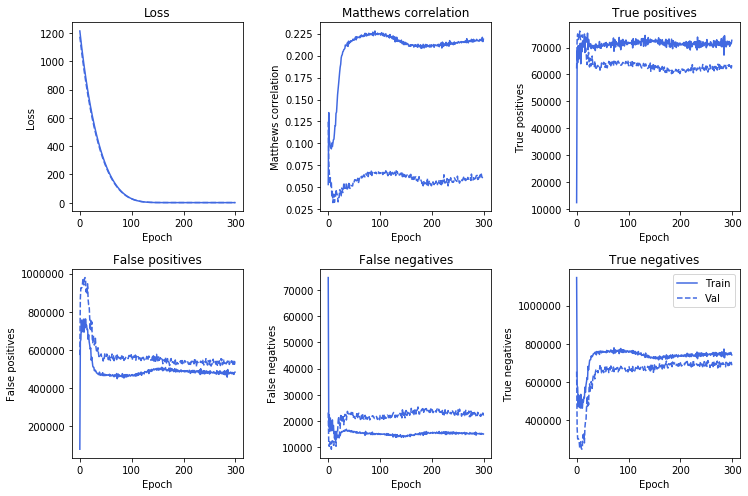

In [28]:
metric_names =  [
    'loss', 
    'matthews_correlation', 
    'true_positives', 
    'false_positives', 
    'false_negatives', 
    'true_negatives'
]

filename = '../project_info/figures/parallel_LSTM_learning_curves.png'
print(f"Total observations: {len(training_data)}")
plotting_functions.plot_metrics(history, metric_names, filename)

In [29]:
training_predictions = model.predict(x_training)
training_ignition_risk_predictions = training_predictions.flatten()
training_true_fires = y_training.flatten()

testing_predictions = model.predict(x_testing)
testing_ignition_risk_predictions = testing_predictions.flatten()
testing_true_fires = y_testing.flatten()

In [30]:
x_training[0].shape

(3264, 5, 22)

In [31]:
training_predictions

array([[0.3227494 , 0.4005156 , 0.48171785, ..., 0.30611485, 0.2252251 ,
        0.1879989 ],
       [0.31712207, 0.3885399 , 0.46931323, ..., 0.29380554, 0.21129574,
        0.17592217],
       [0.32230735, 0.3986086 , 0.47819394, ..., 0.30529922, 0.2225008 ,
        0.18625253],
       ...,
       [0.31695065, 0.39204562, 0.4746868 , ..., 0.29481405, 0.21653685,
        0.17811239],
       [0.31440598, 0.38573307, 0.46777713, ..., 0.29041627, 0.21011257,
        0.17362222],
       [0.31653705, 0.39105678, 0.4731521 , ..., 0.2950122 , 0.21617155,
        0.17829645]], dtype=float32)

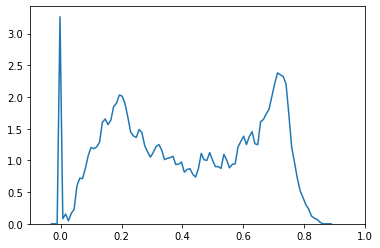

In [32]:
sns.kdeplot(training_ignition_risk_predictions, cumulative=False, bw=0.01)
plt.xlim(-0.1, 1)
plt.show()

In [33]:
training_results = model.evaluate(
    x_training,
    y_training 
)

testing_results = model.evaluate(
    x_testing,
    y_testing 
)

2176/2176 [==============================] - 12s 6ms/sample - loss: 1.0253 - true_positives: 42067.0000 - false_positives: 362276.0000 - true_negatives: 472246.0000 - false_negatives: 15571.0000 - auc: 0.7060 - matthews_correlation: 0.0588


loss :  0.5969659011153614
true_positives :  73244.0
false_positives :  487241.0
true_negatives :  762586.0
false_negatives :  15169.0
auc :  0.79757273
matthews_correlation :  0.09924913

Training data prediction results
No fire (True Negatives):  761473
False alarms (False Positives):  488354
Fires missed (False Negatives):  15085
Fires detected (True Positives):  73328
Total fires:  88413

Test data prediction results
No fire (True Negatives):  472070
False alarms (False Positives):  362452
Fires missed (False Negatives):  15562
Fires detected (True Positives):  42076
Total fires:  57638


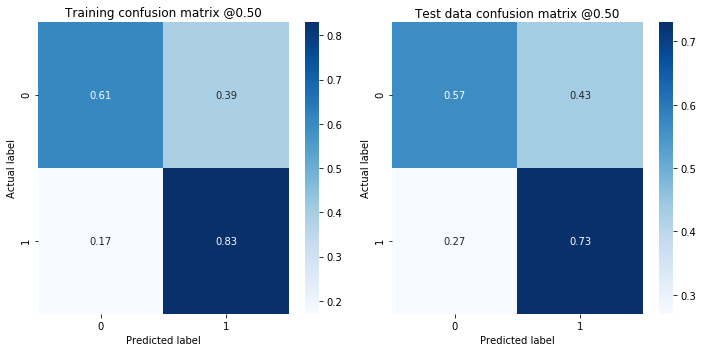

In [34]:
for name, value in zip(model.metrics_names, training_results):
    print(name, ': ', value)
filename ='../project_info/figures/parallel_LSTM_confusion_matricies.png'  
plotting_functions.plot_cm(training_true_fires, training_ignition_risk_predictions, testing_true_fires, testing_ignition_risk_predictions, filename)

In [35]:
def scale_features(data: 'DataFrame', features_to_scale: list, quantile_transformer: str, min_max_scaler: str) -> 'DataFrame':
    '''Takes data and list of weather features, prefit quantile transformer
    and min max scaler. Returns dataframe with weather normalized weather
    features scaled to range of (-1, 1)'''

    # load prefit quantile transformer
    quantile_transformer = load(open(quantile_transformer, 'rb'))

    # run box cox transform on features of intrest
    normalized_data = pd.DataFrame(quantile_transformer.transform(
        data[features_to_scale]), columns=features_to_scale)
    data[features_to_scale] = normalized_data

    # load prefit min max scaler
    min_max_scaler = load(open(min_max_scaler, 'rb'))

    # scale features of intrest
    scaled_features = min_max_scaler.transform(data[features_to_scale])
    data[features_to_scale] = scaled_features

    # reset dtypes of transformed features
    data[features_to_scale] = data[features_to_scale].astype('float32')

    # return resulting dataframe
    return data

def onehot_month(data: 'DataFrame') -> 'DataFrame':
    '''Takes dataframe with pandas datetime column and 
    onehot encodes month. Returns dataframe'''

    month_names = [
        'January',
        'February',
        'March',
        'April',
        'May',
        'June',
        'July',
        'August',
        'September',
        'October',
        'November',
        'December'
    ]

    # setup onehot encoder using 12 catagories for the months
    # and output dtype of single precision float
    onehot_encoder = OneHotEncoder(
        categories=[np.arange(1, 13, 1)],
        sparse=False,
        dtype=np.float32
    )

    # get months from each row of data, reshape from wide to long
    month = np.array(pd.DatetimeIndex(data['date']).month).reshape(-1, 1)

    # onehot encode
    onehot_month = onehot_encoder.fit_transform(month)
    # print(onehot_month)

    # convert to pandas dataframe with named columns
    onehot_month_df = pd.DataFrame(onehot_month, columns=month_names)

    # reset indexes
    onehot_month_df.reset_index(drop=True, inplace=True)
    data.reset_index(drop=True, inplace=True)

    # join months back to data along rows
    data = pd.concat([data, onehot_month_df], axis=1)

    return data


def format_data(input_data: 'DataFrame', shape_parameters: dict) -> 'numpy.ndarray':
    '''takes dataframe and information about desired output shape (history window size,
    target window size, timesteps to slide history window) and returns a formatte list'''

    # get nessecary shape parameters into named varible for ease of use
    history_size = shape_parameters['history_size']
    target_size = shape_parameters['target_size']
    step = shape_parameters['step']

    # empty dataframe to hold samples
    data_list = []

    # break dataframe into spatial bins by lat lon
    spatial_bins = input_data.groupby(['lat', 'lon'])

    # loop on spatial bins and split each into test and training sets
    for bin_name, spatial_bin in spatial_bins:

        # sort bin by date and convert to numpy array
        # sort bin by date, then drop date column
        spatial_bin = spatial_bin.sort_values('date')
        spatial_bin.drop('date', axis=1, inplace=True)
        spatial_bin = np.array(spatial_bin.values)

        bin_data = []

        # set start and end - note: some trimming is
        # necessary here so that the target (in the future)
        # does not slide off the end of the array as we
        # move the history window forward
        start_index = history_size
        end_index = len(spatial_bin) - target_size

        # loop over the history window in steps of step size
        # grab a time block of data with length history_size
        # and the corresponding labels
        for i in range(start_index, end_index):
            indices = range(i - history_size, i, step)
            bin_data.append(spatial_bin[indices])
        # add to master
        data_list.append(np.array(bin_data))

    return data_list

def format_for_api(data: 'numpy.ndarray', lat_lon_bins: list, date_list: list) -> 'DataFrame':
    '''Takes a 3D numpy array of predictions by day and location with a list of lat lon bins
    returns a formatted dataframe containing predictions by day and location'''

    # Load orignal lat lon bins
    lat_lon_bins = pd.DataFrame(lat_lon_bins, columns=['lat', 'lon'])

    # construct prediction date list (7 future days from today)
    #date_list = pd.date_range(datetime.today(), periods=7).tolist()

    # loop on the first dimension of the numpy prediction array (days)
    i = 0
    days = []
    for day in data:
        # 410 is the number of spatial bin, reshape from wide to long
        # so we can make the risk prediction value a column in a dataframe
        ignition_risk = day.reshape((410, 1))
        ignition_risk = pd.DataFrame(data=ignition_risk.flatten(),
                                     columns=['ignition_risk'])

        # add day column
        ignition_risk['day'] = date_list[i].date()

        # add lat, lon bins
        ignition_risk = pd.concat([ignition_risk, lat_lon_bins], axis=1)

        # add day worth of prediction data we just constructed to
        # growing master list
        days.append(ignition_risk)

        i += 1

    # concatenate over days
    predictions = pd.concat(days)

    # set dtype of date & format
    predictions['day'] = pd.to_datetime(
        predictions['day'])

    # Note our time resolution is at the level of days,
    # so we don't want the time in our date column pyarrow
    # seems to have trouble with when saving the dataframe
    # to parquet so we convert the date to string
    predictions['day'] = predictions['day'].dt.date.astype(str)

    # return resulting dataframe
    return predictions

In [36]:
data_file = config.training_data_file
features = config.features

features_to_scale = [
    'temp',
    'rain',
    'humidity',
    'dew_point',
    'pressure',
    'uwind',
    'vwind',
    'cloud_cover',
]

shape_parameters = {
    'history_size': 5,         # size of past history time chunk
    'target_size': 1,          # number of timepoints to predict from each history time chunk
    'step': 1                  # number of timepoints to move the history time chunk
}

quantile_transformer = '../deployment/src//data/quantile_transformer'
min_max_scaler = '../deployment/src//data/min_max_scaler'
weights_file = '../deployment/src/models/parallel_LSTM_weights.tf'
lat_lon_bins_file_name = '../deployment/data/intermediate/california_geospatial_bins.csv'
states_shapefile = '../training_data_pipeline/data/spatial_data/cb_2018_us_state_500k.shp'

In [37]:
import csv
from pickle import load
from descartes import PolygonPatch

raw_data = pd.read_parquet(data_file)
data = raw_data[features]

data.rename(columns={
    "mean_air_2m": "temp", 
    "mean_apcp": "rain",
    "mean_rhum_2m": "humidity",
    "mean_dpt_2m": "dew_point",
    "mean_pres_sfc": "pressure",
    "mean_uwnd_10m": "uwind",
    "mean_vwnd_10m": "vwind",
    "mean_cloud_cover": "cloud_cover"
    
}, inplace=True)

prediction_data = data.drop('ignition', axis=1)

with open(lat_lon_bins_file_name, 'r') as lat_lon_bins_file:
    rows = csv.reader(lat_lon_bins_file)
    lat_lon_bins = list(rows)
    
date_list = pd.DatetimeIndex(prediction_data['date'].unique())

california = data_functions.get_california_polygon(states_shapefile)
multipoly = california.loc[16, 'geometry']
california_land_mass = multipoly[-1]

In [38]:
prediction_data = scale_features(prediction_data, features_to_scale, quantile_transformer, min_max_scaler)
prediction_data = onehot_month(prediction_data)
prediction_data = format_data(prediction_data, shape_parameters)

for i in range(len(prediction_data)):
    start_index = (prediction_data[i].shape[0] - (prediction_data[i].shape[0] % BATCH_SIZE))
    end_index = prediction_data[i].shape[0]

    prediction_data[i] = np.delete(prediction_data[i], range(start_index, end_index), axis=0)
    
predictions = model.predict(prediction_data)
formatted_predictions = format_for_api(predictions, lat_lon_bins, date_list)

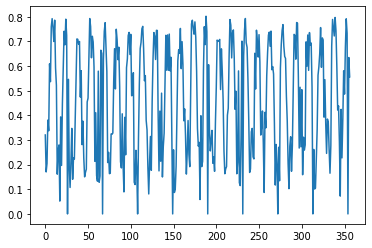

In [39]:
one_bin = formatted_predictions[(data['lat'] == 32.683891) & (data['lon'] == -117.180901)]
one_bin = one_bin.iloc[::10000, :]
one_bin.reset_index(drop=True, inplace=True)
plt.plot(one_bin.index, one_bin['ignition_risk'])
plt.show()

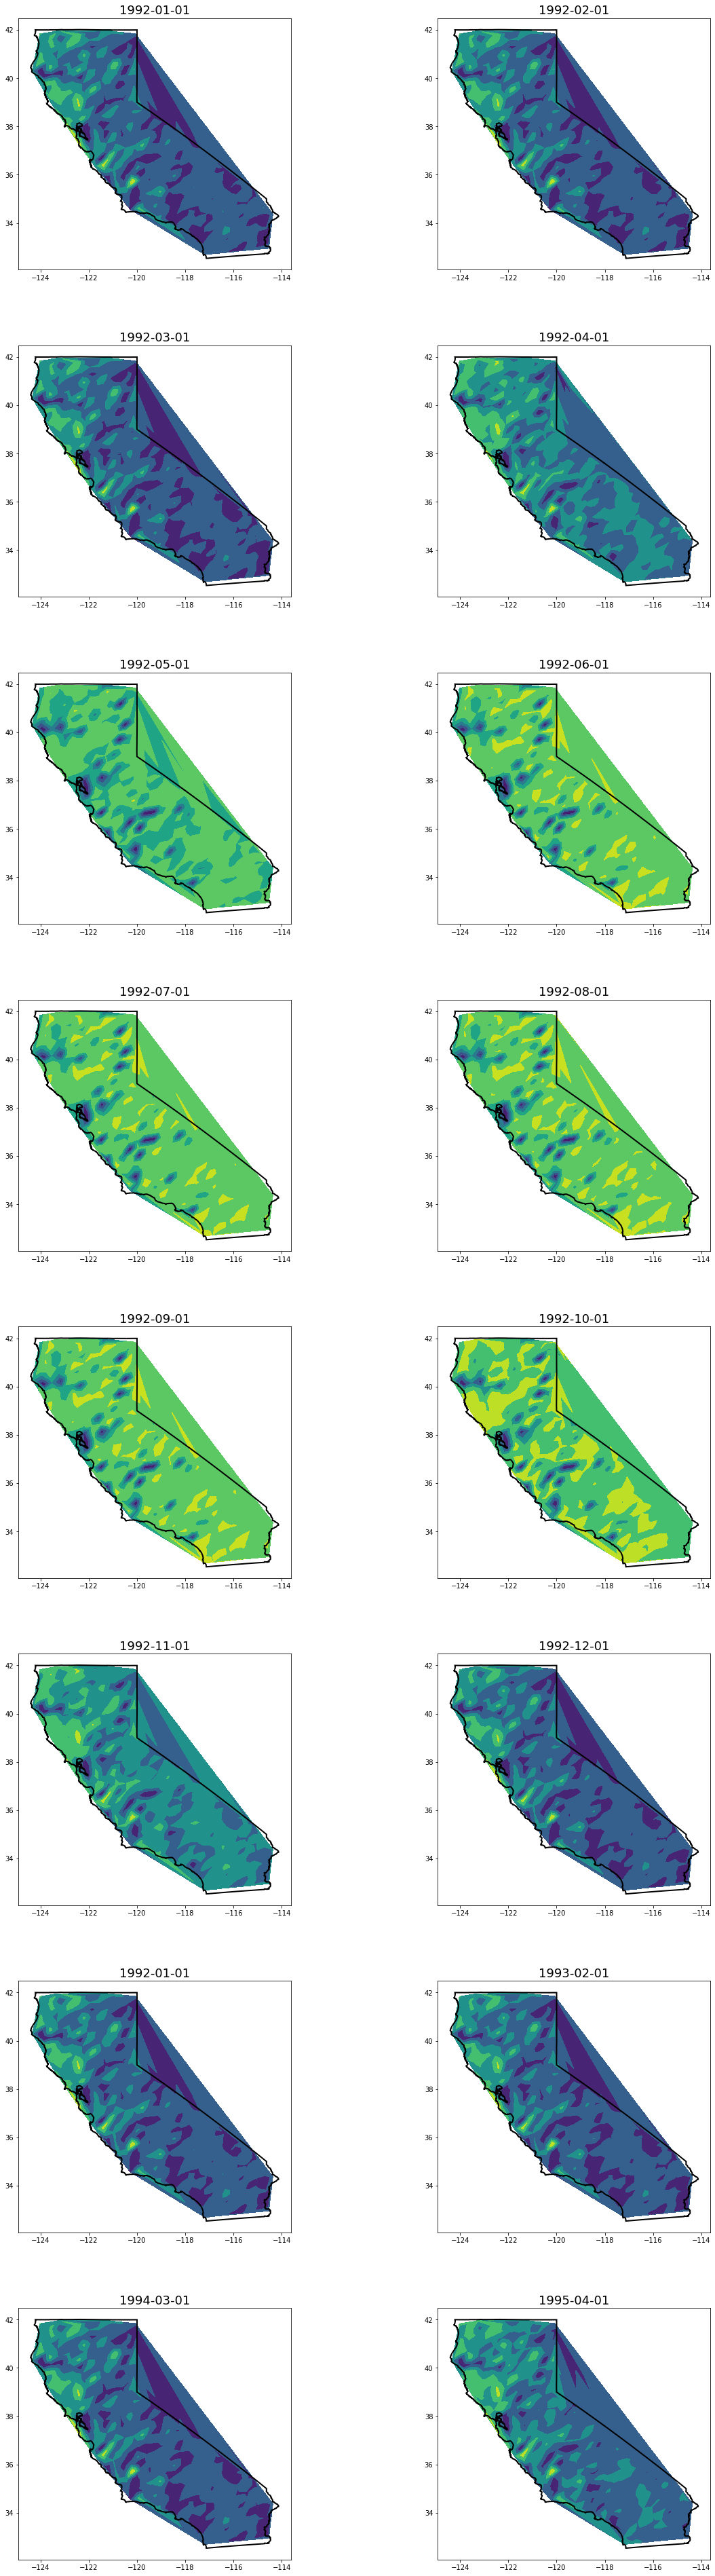

In [45]:
left  = 0.125  # the left side of the subplots of the figure
right = 0.65   # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

fig_rows = 8
fig_cols = 2
plot_height = 65
plot_width = 30

plot_locations = [
    (0,0),(0,1),
    (1,0),(1,1),
    (2,0),(2,1),
    (3,0),(3,1),
    (4,0),(4,1),
    (5,0),(5,1),
    (6,0),(6,1),
    (7,0),(7,1)
]

date_list = [
    '1992-01-01',
    '1992-02-01',
    '1992-03-01',
    '1992-04-01',
    '1992-05-01',
    '1992-06-01',
    '1992-07-01',
    '1992-08-01',
    '1992-09-01',
    '1992-10-01',
    '1992-11-01',
    '1992-12-01',
    '1992-01-01',
    '1993-02-01',
    '1994-03-01',
    '1995-04-01'
    
]

num_contour_levels = 5

formatted_predictions['lat'] = formatted_predictions['lat'].astype('float32')
formatted_predictions['lon'] = formatted_predictions['lon'].astype('float32')

prediction_data_by_day = formatted_predictions.groupby('day')

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(plot_width, plot_height))
fig.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

i = 0

while i < 16:
    day = str(date_list[i])
    predictions = prediction_data_by_day.get_group(day)
    predictions.drop('day', axis=1, inplace=True)

    xi, yi, zi = data_functions.regularize_grid(predictions, 'ignition_risk', 0.01)

    ax[plot_locations[i]].add_patch(PolygonPatch(california_land_mass, fc='none', ec='black', lw='2', zorder=2))
    ax[plot_locations[i]].contourf(xi, yi, zi, num_contour_levels, cmap='viridis')
    ax[plot_locations[i]].set_title(day, fontsize=18)
    ax[plot_locations[i]].set_aspect('equal', adjustable='box')
    
    i += 1

# 4. Save model for deployment

In [47]:
# save trained weights
model.save_weights('./trained_model_weights/parallel_LSTM_weights.tf')

In [ ]:
# save model
tf.saved_model.save(model, './trained_models/parallel_LSTM.tf')

Mock up some data to match what the live prediction data will look like to ensure the model works as expected after round tripping the weights.

In [42]:
past_history = 5
future_target = 1
step = 1
BATCH_SIZE = 1

x_training, y_training = data_functions.format_features_labels_for_LSTM(
    training_data,        # incomming_data
    past_history,         # size of past history time chunk
    future_target,        # number of future timepoints to predict from each history time chunk
    step,                 # number of timepoints to move the history time chunk as we slide over the data
)

x_training, y_training = data_functions.trim_and_reshape_for_LSTM(x_training, y_training)

for i in range(len(x_training)):
    start_index = (x_training[i].shape[0] - (x_training[i].shape[0] % BATCH_SIZE))
    end_index = x_training[i].shape[0]

    x_training[i] = np.delete(x_training[i], range(start_index, end_index), axis=0)

In [43]:
mock_data = []

for spatial_bin in x_training:
    bin_slice = spatial_bin[0:7,:,]
    mock_data.append(bin_slice)
    
mock_labels = y_training[0:7]
    
print("x_training is {}, length: {}, member shape: {}.".format(type(x_training), len(x_training), x_training[0].shape))
print("y_training is {}, length: {}, member shape: {}.".format(type(y_training), len(y_training), y_training[0].shape))
print("mock_data is {}, length: {}, member shape: {}.".format(type(mock_data), len(mock_data), mock_data[0].shape))
print("mock_labels are {}, length: {}, member shape: {}.".format(type(mock_labels), len(mock_labels), mock_labels[0].shape))

x_training is <class 'list'>, length: 410, member shape: (3281, 5, 22).
y_training is <class 'list'>, length: 3281, member shape: (410,).
mock_data is <class 'list'>, length: 410, member shape: (7, 5, 22).
mock_labels are <class 'list'>, length: 7, member shape: (410,).


In [44]:
inputs = []
LSTMs = []

for i in range(len(mock_data)):
    inputs.append(
        keras.Input(
            batch_shape=(
                BATCH_SIZE,
                mock_data[0].shape[1],
                mock_data[0].shape[2]
            )
        )
    )
    
for i in range(len(mock_data)):
    LSTMs.append(keras.layers.LSTM(
        lstm_units,
        dropout = variational_dropout,
        stateful = True
    )(inputs[i]))
    
merged = keras.layers.concatenate(LSTMs)

hidden1 = keras.layers.Dense(
    hidden_units,
    kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
    bias_initializer=tf.keras.initializers.he_normal(),
    activation = 'relu'
)(merged)

hidden2 = keras.layers.Dense(
    hidden_units,
    kernel_regularizer=keras.regularizers.l1(hidden_l1_lambda),
    bias_initializer=tf.keras.initializers.he_normal(),
    activation = 'relu'
)(hidden1)

output = keras.layers.Dense(
    410,
    activation = 'sigmoid',
    bias_initializer = output_bias
)(hidden2)

production_model = keras.Model(inputs=inputs, outputs=output)

production_model.load_weights('./trained_model_weights/parallel_LSTM_weights.tf')
production_model.summary()

NameError: name 'lstm_units' is not defined

In [ ]:
mock_predictions = production_model.predict(mock_data)
flat_mock_predictions = mock_predictions.flatten()

In [ ]:
sns.kdeplot(flat_mock_predictions, cumulative=False, bw=0.01)
plt.xlim(-0.1, 1)
plt.show()